# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import string

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [3]:
dataset = pd.read_csv("/content/drive/MyDrive/Indonesian-Twitter-Emotion-Dataset-master/Twitter_Emotion_Dataset.csv")
dataset.head()
texts = dataset[['tweet']]
dataset.label

0         anger
1         anger
2         happy
3         anger
4         happy
         ...   
4396       love
4397       fear
4398      anger
4399      happy
4400    sadness
Name: label, Length: 4401, dtype: object

In [4]:
happy = 0
fear = 0
love = 0
sadness = 0
anger = 0
for label in dataset.label:
  if(label == 'happy'):
    happy+=1
  elif(label == 'fear'):
    fear+=1
  elif(label == 'sadness'):
    sadness+=1
  elif(label =='love'):
    love+=1
  elif(label == 'anger'):
    anger+=1
print("Happy:",happy)
print("fear:",fear)
print("sadness:",sadness)
print("love:",love)
print("anger:",anger)


Happy: 1017
fear: 649
sadness: 997
love: 637
anger: 1101


### ***Pre processing***

# 1. Remove ["[USERNAME]", "[URL]", "[SENSITIVE-NO]"]

In [5]:
def remove_term(texts):
    term = ["[USERNAME]", "[URL]", "[SENSITIVE-NO]"]
    textwords = texts.split()
    termfreewords = [word for word in textwords if word not in term]
    termfree = ' '.join(termfreewords)
    return termfree

texts['termfree_msg'] = texts['tweet'].apply(lambda x:remove_term(x))


# 2. Case Folding

# - Remove Punctuation


In [6]:
# def remove_punctuation(texts):
#     # punctuationfree="".join([i for i in texts if i not in string.punctuation])
#     exclude = string.punctuation
#     punctuationfree = "".join([(ch if ch not in exclude else " ") for ch in texts])
#     return punctuationfree
# #storing the puntuation free text
# texts['clean_msg']= texts['termfree_msg'].apply(lambda x:remove_punctuation(x))
# texts.head()

# - Lower case the text

In [7]:
# lower case 
texts['lower']= texts['termfree_msg'].apply(lambda x: x.lower())
texts.head()

,tweet,termfree_msg,lower
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...","Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...","soal jln jatibaru,polisi tdk bs gertak gubernu..."
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...","Sesama cewe lho (kayaknya), harusnya bisa lebi...","sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,kepingin gudeg mbarek bu hj. amad foto dari go...
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...","Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...","jln jatibaru,bagian dari wilayah tn abang.peng..."
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...","Sharing pengalaman aja, kemarin jam 18.00 bata...","sharing pengalaman aja, kemarin jam 18.00 bata..."


# 3.Tokenization

In [8]:
import re

def tokenization(texts):
    tokens = re.split('\W',texts)
    return tokens
    
#applying function to the column
texts['token']= texts['lower'].apply(lambda x: tokenization(x))

texts['token']

0       [soal, jln, jatibaru, polisi, tdk, bs, gertak,...
1       [sesama, cewe, lho, , kayaknya, , , harusnya, ...
2       [kepingin, gudeg, mbarek, bu, hj, , amad, foto...
3       [jln, jatibaru, bagian, dari, wilayah, tn, aba...
4       [sharing, pengalaman, aja, , kemarin, jam, 18,...
                              ...                        
4396    [tahukah, kamu, , bahwa, saat, itu, papa, meme...
4397    [sulitnya, menetapkan, calon, wapresnya, jokow...
4398    [5, , masa, depannya, nggak, jelas, , lha, iya...
4399    [dulu, beneran, ada, mahasiswa, teknik, ui, ne...
4400    [ya, allah, , hanya, engkau, yang, mengetahui,...
Name: token, Length: 4401, dtype: object

# 4.Change singkatan to formal word

In [9]:
def change_singkatan_into_formal_word(text):
  formal_text = [singkatan.hasil[singkatan.index[singkatan.singkatan == word].tolist()[0]].strip()\
    if word in singkatan.singkatan.values else word for word in text]
  return formal_text

# Remove singkatan using  kamus_singkatan.csv
singkatan = pd.read_csv("/content/drive/MyDrive/Indonesian-Twitter-Emotion-Dataset-master/kamus_singkatan.csv")
data_text= []
for i,sentence in enumerate(texts['token']):
    data_text.append(change_singkatan_into_formal_word(sentence))

In [10]:
pip install sastrawi

     |████████████████████████████████| 209 kB 5.2 MB/s 


In [11]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [12]:
print(data_text[0])

['soal', 'jalan', 'jatibaru', 'polisi', 'tidak', 'bisa', 'gertak', 'gubernur', '', 'emangny', 'polisi', 'tidak', 'ikut', 'pmbhasan', '', 'jangan', 'berpolitik', '', 'pengaturan', 'wilayah', 'hak', 'gubernur', '', 'persoalan', 'tn', 'abang', 'soal', 'turun', 'temurun', 'pelik', 'perlu', 'kesabaran', '']


# 5.Removing stop words and null value

In [13]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [14]:
#Removing stop word and null value
text_after_pre = []
for text in data_text:
  list_word = []
  string = ""
  for idx,word in enumerate(text):
    if(word!='' and word not in stopwords):
      list_word.append(word)
      if((idx+1) == len(text) ):
        string+=word
      else:
        string+=word + " "
  text_after_pre.append(string)


In [15]:
print(text_after_pre[2])
print(len(text_after_pre[2]))
print(len(text_after_pre[2].split()))

kepingin gudeg mbarek bu hj amad foto google sengaja biar teman teman membayangkannya berbagi indah 
100
15


In [16]:
# data_cleaned = []
# for text in text_after_pre:
#   hasil = stemmer.stem(text)
#   data_cleaned.append(hasil)
# print(len(data_cleaned))

# !Pretrained Using Glove


In [17]:
def prepare_model_input(X_train, X_test,MAX_NB_WORDS=10000,MAX_SEQUENCE_LENGTH=68):
    #Text to pad_sequences
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer()
 
    tokenizer.fit_on_texts(text)

    # Change it to sequences
    sequences = tokenizer.texts_to_sequences(text)
    # Word_index => A dictionary of words and their uniquely assigned integers
    word_index = tokenizer.word_index
    # ensure that all sequences in a list have the same length
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)

    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]

    # Now to create the word embeddings; first, we need to create a dictionary holding each word and its respective vector
    embeddings_dict = {}
    f = open("/content/drive/MyDrive/Indonesian-Twitter-Emotion-Dataset-master/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)



In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(handle_unknown='ignore')
# Y = enc.fit_transform(np.array(df[0]).reshape(-1,1)).toarray()
from tensorflow.keras.utils import to_categorical

In [19]:
#Max sequence length
max = 0
for text in text_after_pre:
  if(len(text.split())>max):
    max = len(text.split())
    
print(max)


68


In [20]:
X = text_after_pre

y =  le.fit_transform(dataset.label)
y = to_categorical(y)
# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2,shuffle=True)

print("Preparing model input ...")
# Pre trained glove
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size = 0.2,shuffle=True)

X_train = np.concatenate((X_train,X_train2),axis=0)
y_train = np.concatenate((y_train,y_train2),axis=0)

X_test = np.concatenate((X_test,X_test2),axis=0)
y_test = np.concatenate((y_test,y_test2),axis=0)
print("Len of X_train = ",len(X_train))
print("Len of X_test = ",len(X_test))
# print("Len of X_val = ",len(X_val))

Preparing model input ...
Len of X_train =  6336
Len of X_test =  1585


In [21]:
print(len(y_test))

1585


In [22]:
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train,X_test)


print("Done!")

Found 18526 unique tokens.
(7921, 68)
Total 400000 word vectors.
Done!


# Create embedding matrix

In [23]:
embedding_matrix = np.random.random((len(word_index) + 1, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        if len(embedding_matrix[i]) != len(embedding_vector):
            print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                  "into shape", str(len(embedding_vector)), " Please make sure your"
                                                            " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
            exit(1)
        embedding_matrix[i] = embedding_vector
print(embedding_matrix[word_index['tidak']])

[-0.48289001  0.20392001  0.45903999  0.038786   -0.09415    -0.62316
  1.8003      0.15637    -0.12574001  0.63155001  0.42006999  0.78017998
  0.19780999  0.44953999  0.58802003  0.064577   -0.46528     0.095197
  0.76068002  0.75366998 -0.56775999  0.45908001  0.74886     0.13063
  1.01139998  0.9752      0.51475    -0.26914999 -0.1425      0.89488
 -1.51359999  0.42719999  0.31139001  0.89723003 -0.95657003 -0.91882998
  0.37211999 -0.51911002 -0.18426999 -0.038414   -0.0037454  -0.48157001
  0.56906003  0.33829001  0.53009999 -0.92483997 -0.090862   -0.1309
  0.87589002  1.17340004]


# Model Bilstm

In [34]:
model_glove = Sequential()
model_glove.add(Embedding(len(word_index)+1, 50, input_length=68, weights=[embedding_matrix], trainable=True))
model_glove.add(Bidirectional(LSTM(64, return_sequences=True)))
model_glove.add(Dropout(0.5))
model_glove.add(BatchNormalization())
model_glove.add(Bidirectional(LSTM(32, return_sequences=True)))
model_glove.add(Dropout(0.3))
model_glove.add(BatchNormalization())
model_glove.add(Bidirectional(LSTM(32)))
model_glove.add(BatchNormalization())
model_glove.add(Dropout(0.4))
model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dense(32, activation='relu'))
model_glove.add(Dense(16, activation='relu'))
model_glove.add(Dense(8, activation='relu'))
model_glove.add(Dense(5, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_glove.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 68, 50)            926350    
                                                                 
 bidirectional_3 (Bidirectio  (None, 68, 128)          58880     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 68, 128)           0         
                                                                 
 batch_normalization_4 (Batc  (None, 68, 128)          512       
 hNormalization)                                                 
                                                                 
 bidirectional_4 (Bidirectio  (None, 68, 64)           41216     
 nal)                                                            
                                                      

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model_glove.fit(X_train_Glove, y_train,
                           validation_split=0.2,
                           epochs=20,
                          callbacks = [es_callback],
                           batch_size=32,
                           verbose=1)

Epoch 1/20
159/159 [==============================] - 49s 232ms/step - loss: 1.6161 - accuracy: 0.2283 - val_loss: 1.5922 - val_accuracy: 0.2579
Epoch 2/20
159/159 [==============================] - 37s 230ms/step - loss: 1.5916 - accuracy: 0.2457 - val_loss: 1.5777 - val_accuracy: 0.2634
Epoch 3/20
159/159 [==============================] - 35s 222ms/step - loss: 1.5638 - accuracy: 0.2703 - val_loss: 1.6113 - val_accuracy: 0.2831
Epoch 4/20
159/159 [==============================] - 34s 216ms/step - loss: 1.4507 - accuracy: 0.3506 - val_loss: 1.6836 - val_accuracy: 0.2429
Epoch 5/20
159/159 [==============================] - 34s 215ms/step - loss: 1.3099 - accuracy: 0.4501 - val_loss: 1.3022 - val_accuracy: 0.4511
Epoch 6/20
159/159 [==============================] - 36s 224ms/step - loss: 1.1412 - accuracy: 0.5280 - val_loss: 1.3809 - val_accuracy: 0.4779
Epoch 7/20
159/159 [==============================] - 34s 217ms/step - loss: 0.9797 - accuracy: 0.5845 - val_loss: 1.4132 - val_ac

# Plotting


In [36]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

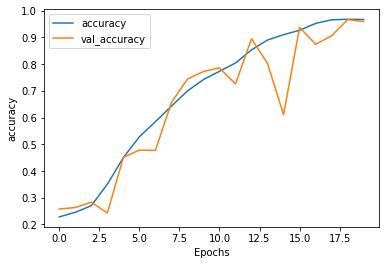

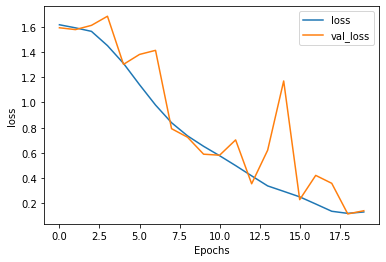

In [37]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Testing accuracy

In [38]:
print("\n Evaluating Model ... \n")
predicted = model_glove.predict(X_test_Glove)
print(metrics.confusion_matrix(np.argmax(y_test, axis=1),np.argmax(predicted, axis=1)))



 Evaluating Model ... 

[[217 120   5   9  74]
 [ 12 167   4   2  63]
 [  2  18 216   8 128]
 [  3   2   8 146  56]
 [ 10  31  10  13 261]]


In [39]:
true = 0
for pred ,real in zip(predicted,y_test):

  if(np.argmax(pred) == np.argmax(real)):
    true+=1
print(len(y_test))
print(true)

print("Test_accuracy: ",(true/len(y_test)) *100 , "%")

1585
1007
Test_accuracy:  63.53312302839117 %


In [40]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1),np.argmax(predicted, axis=1)))

              precision    recall  f1-score   support

           0       0.89      0.51      0.65       425
           1       0.49      0.67      0.57       248
           2       0.89      0.58      0.70       372
           3       0.82      0.68      0.74       215
           4       0.45      0.80      0.58       325

    accuracy                           0.64      1585
   macro avg       0.71      0.65      0.65      1585
weighted avg       0.73      0.64      0.65      1585

